# Federated Insurance

## Prerequisites
---

In [127]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split


from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_fed
#import FLutils

## Data preperation
---

In [2]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

df.loc[:, [target]+features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


In [4]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 10), (364, 10), (325, 10), (324, 10)]


## Evaluation split
---

In [5]:
# create evaluation splits
# ========================

nfolds, nreps = 5, 5

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [25, 25, 25, 25]


## Federated Learning
---

In [39]:
# define model architecture
def keras_blueprint(compile = False):
    return create_keras_model(
        nfeatures = 9, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

keras_blueprint().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 40)                400       
                                                                 
 dense_9 (Dense)             (None, 40)                1640      
                                                                 
 dense_10 (Dense)            (None, 20)                820       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


### Train

In [232]:
# compute train

results_fed = []

for eval_ind in tqdm.tqdm(range(nreps * nfolds)):

    # fetch train, eval data and prep it
    train_data_fed = []
    eval_data_fed  = []

    for client_ind in range(len(clients)):
        indices_train = client_splits[client_ind][eval_ind][0]

        data = clients[client_ind].iloc[indices_train]
        train_data, eval_data = train_test_split(data, test_size = 0.1, random_state = 42)

        train_data_fed.append(prep_fed_train(train_data[features], train_data[target])) 
        eval_data_fed.append(prep_fed_test(eval_data[features], eval_data[target]))
        
    # train
    result = train_fed(
        model = model_fn(keras_creator = keras_blueprint),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        NUM_ROUNDS = 50,
        NUM_EPOCHS = 50,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = True
    )

    results_fed.append(result)

  0%|          | 0/25 [00:00<?, ?it/s]2023-05-12 04:31:59.470842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:31:59.470901: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:31:59.470997: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:31:59.471307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:31:59.471362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5824.992, 'mean_squared_error': 102362640.0, 'loss': 5849.947, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14236.82, 'mean_squared_error': 367672000.0, 'loss': 14347.774, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5406.9956, 'mean_squared_error': 92689976.0, 'loss': 5429.6733, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14234.264, 'mean_squared_error': 367587550.0, 'loss': 14345.196, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5243.185, 'mean_squared_error': 88413140.0, 'loss': 5264.9497, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14226.108, 'mean_squared_error': 367316350.0, 'loss': 14337.005, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5082.358, 'mean_squared_error': 84319770.

  4%|▍         | 1/25 [00:21<08:27, 21.14s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2055.539, 'mean_squared_error': 23906656.0, 'loss': 2063.266, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3261.7632, 'mean_squared_error': 48068828.0, 'loss': 3262.0378, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:32:20.549912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:20.549974: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:32:20.550074: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:32:20.550481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:20.550554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:20.550605: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5774.101, 'mean_squared_error': 103512290.0, 'loss': 5798.176, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13158.367, 'mean_squared_error': 318678700.0, 'loss': 13195.894, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5335.9775, 'mean_squared_error': 92728040.0, 'loss': 5358.289, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13156.002, 'mean_squared_error': 318607900.0, 'loss': 13193.513, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5149.0684, 'mean_squared_error': 87764190.0, 'loss': 5170.509, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13148.48, 'mean_squared_error': 318379400.0, 'loss': 13185.974, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4957.9565, 'mean_squared_error': 83403670.

  8%|▊         | 2/25 [00:42<08:10, 21.32s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 1925.7478, 'mean_squared_error': 22199268.0, 'loss': 1931.29, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2794.8887, 'mean_squared_error': 31925436.0, 'loss': 2781.5886, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:32:42.359501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:42.359576: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:32:42.359708: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:32:42.360089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:42.360152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:42.360196: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5852.1455, 'mean_squared_error': 102339340.0, 'loss': 5876.6953, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13153.374, 'mean_squared_error': 335924160.0, 'loss': 13195.758, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5452.373, 'mean_squared_error': 92711460.0, 'loss': 5475.121, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13150.924, 'mean_squared_error': 335850370.0, 'loss': 13193.292, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5271.4985, 'mean_squared_error': 88506280.0, 'loss': 5293.518, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13143.214, 'mean_squared_error': 335615420.0, 'loss': 13185.563, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5110.854, 'mean_squared_error': 84704184

 12%|█▏        | 3/25 [01:05<08:09, 22.25s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2152.8813, 'mean_squared_error': 26767240.0, 'loss': 2158.488, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3630.0117, 'mean_squared_error': 49154230.0, 'loss': 3705.9841, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:33:06.408793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:06.408847: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:33:06.408987: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:33:06.409371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:06.409444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:06.409493: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5773.9595, 'mean_squared_error': 100876460.0, 'loss': 5776.8604, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11251.445, 'mean_squared_error': 228382110.0, 'loss': 11243.027, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5372.0874, 'mean_squared_error': 91212370.0, 'loss': 5372.7363, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11248.965, 'mean_squared_error': 228319790.0, 'loss': 11240.531, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5208.153, 'mean_squared_error': 87151140.0, 'loss': 5207.895, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11241.208, 'mean_squared_error': 228124720.0, 'loss': 11232.769, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5049.2915, 'mean_squared_error': 832706

 16%|█▌        | 4/25 [01:29<07:54, 22.57s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2008.0793, 'mean_squared_error': 23397138.0, 'loss': 1993.3596, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2065.998, 'mean_squared_error': 25389980.0, 'loss': 2053.3464, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:33:28.154997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:28.155063: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:33:28.155170: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:33:28.155538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:28.155608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:28.155654: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5957.9395, 'mean_squared_error': 104761416.0, 'loss': 5974.7026, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12941.683, 'mean_squared_error': 315933570.0, 'loss': 12956.155, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5577.3403, 'mean_squared_error': 95352840.0, 'loss': 5591.2197, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12939.274, 'mean_squared_error': 315862180.0, 'loss': 12953.731, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5357.732, 'mean_squared_error': 90480616.0, 'loss': 5370.6143, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12931.899, 'mean_squared_error': 315638500.0, 'loss': 12946.338, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5218.42, 'mean_squared_error': 8673293

 20%|██        | 5/25 [01:50<07:23, 22.18s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2176.2258, 'mean_squared_error': 26479878.0, 'loss': 2178.504, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 3076.379, 'mean_squared_error': 41249824.0, 'loss': 3057.8857, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:33:49.896572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:49.896635: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:33:49.896752: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:33:49.897093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:49.897154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:49.897196: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5851.5767, 'mean_squared_error': 103360870.0, 'loss': 5876.535, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13285.1, 'mean_squared_error': 320921150.0, 'loss': 13301.163, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5390.798, 'mean_squared_error': 92482420.0, 'loss': 5414.0166, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13282.682, 'mean_squared_error': 320846200.0, 'loss': 13298.73, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5245.3115, 'mean_squared_error': 88581540.0, 'loss': 5267.2993, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13275.121, 'mean_squared_error': 320609120.0, 'loss': 13291.155, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5079.585, 'mean_squared_error': 84539330.0

In [ ]:
# show final train result
pd.DataFrame([result['history'][-1] for result in results_fed]).describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,5.00,5.00,5.00,5.00,5.00,5.00,5.0,5.00,5.0,5.0
mean,2063.69,24550036.00,2064.98,48120.00,378.20,2965.81,39157660.0,2972.17,108.0,4.0
std,103.45,1994336.12,105.64,44.72,0.45,587.34,10314693.0,614.49,0.0,0.0
min,1925.75,22199268.00,1931.29,48100.00,378.00,2066.00,25389980.0,2053.35,108.0,4.0
25%,2008.08,23397138.00,1993.36,48100.00,378.00,2794.89,31925436.0,2781.59,108.0,4.0
50%,2055.54,23906656.00,2063.27,48100.00,378.00,3076.38,41249824.0,3057.89,108.0,4.0
75%,2152.88,26479878.00,2158.49,48100.00,378.00,3261.76,48068828.0,3262.04,108.0,4.0
max,2176.23,26767240.00,2178.50,48200.00,379.00,3630.01,49154232.0,3705.98,108.0,4.0


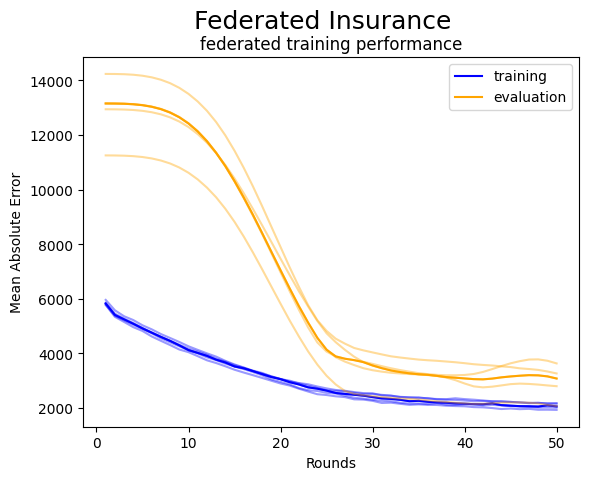

In [225]:
# plot train result

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .4)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .4)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.show()

### Test

In [227]:
# compute test 
results_fed_test = []

for i in tqdm.tqdm(range(nfolds * nreps)):

    # fetch test data
    clients_test = []
    for client_ind in range(len(clients)):
        indices_test = client_splits[client_ind][eval_ind][1]
        clients_test.append(clients[client_ind].iloc[indices_test])

    test_data = pd.concat(clients_test)
    X_test = test_data[features]
    y_test = test_data[target]

    # calculate test performance
    model = keras_blueprint(compile = True)
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)

100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


In [230]:
# show test results
pd.DataFrame(results_fed_test).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,12694.057383,12694.057383,3.009027e+08,-1.302860
std,0.165011,0.165011,4.542141e+03,0.000035
min,12693.771484,12693.771484,3.008951e+08,-1.302943
25%,12693.949219,12693.949219,3.008994e+08,-1.302882
50%,12694.021484,12694.021484,3.009020e+08,-1.302855
75%,12694.177734,12694.177734,3.009057e+08,-1.302835
max,12694.428711,12694.428711,3.009129e+08,-1.302804


## Centralized DNN
---

### Train
---

In [126]:
# compute train
results_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    train_indices = [split[1][0] for split in client_splits]
    #test_indices = [split[1][1] for split in client_splits]

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features]
    y_train = data_train[target]

    model = keras_blueprint(compile = True)
    
    tf.keras.utils.set_random_seed(42)

    hist = model.fit(
        X_train, y_train,
        batch_size = 128, 
        shuffle    = True,
        validation_split = 0.2,
        epochs     = 100,
        verbose    = 2 # one line
        #, callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")]
    )
    results_ctr.append(hist)




Epoch 1/100
7/7 - 1s - loss: 11757.4658 - mae: 11757.4658 - mean_squared_error: 267746096.0000 - r2_score: -5.9795e-01 - val_loss: 6810.8086 - val_mae: 6810.8086 - val_mean_squared_error: 115696416.0000 - val_r2_score: 0.0494 - 651ms/epoch - 93ms/step
Epoch 2/100
7/7 - 0s - loss: 7546.5322 - mae: 7546.5322 - mean_squared_error: 141711552.0000 - r2_score: 0.1244 - val_loss: 7613.7568 - val_mae: 7613.7568 - val_mean_squared_error: 69502032.0000 - val_r2_score: 0.3784 - 476ms/epoch - 68ms/step
Epoch 3/100
7/7 - 1s - loss: 5207.7407 - mae: 5207.7407 - mean_squared_error: 61220440.0000 - r2_score: 0.6153 - val_loss: 8219.8740 - val_mae: 8219.8730 - val_mean_squared_error: 160644864.0000 - val_r2_score: -5.2958e-01 - 502ms/epoch - 72ms/step
Epoch 4/100
7/7 - 1s - loss: 5312.4185 - mae: 5312.4185 - mean_squared_error: 66068020.0000 - r2_score: 0.5888 - val_loss: 4869.2163 - val_mae: 4869.2163 - val_mean_squared_error: 54530160.0000 - val_r2_score: 0.4945 - 507ms/epoch - 72ms/step
Epoch 5/100


In [137]:
# show train results
pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
).describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,1882.20,45.62,1816.59,1837.70,1871.13,1929.60,1978.26
mae,1882.20,45.62,1816.59,1837.70,1871.13,1929.60,1978.26
mean_squared_error,22575412.00,182654.90,22194692.00,22463032.00,22572410.00,22705954.00,22957338.00
r2_score,85.47,0.16,85.20,85.31,85.51,85.58,85.69
val_loss,2098.68,56.70,2015.46,2062.06,2083.06,2126.20,2241.18
val_mae,2098.68,56.70,2015.46,2062.06,2083.06,2126.20,2241.18
val_mean_squared_error,23525394.88,676013.91,22542178.00,22912234.00,23640880.00,23832380.00,25007960.00
val_r2_score,78.09,0.48,77.15,77.79,77.99,78.56,78.77


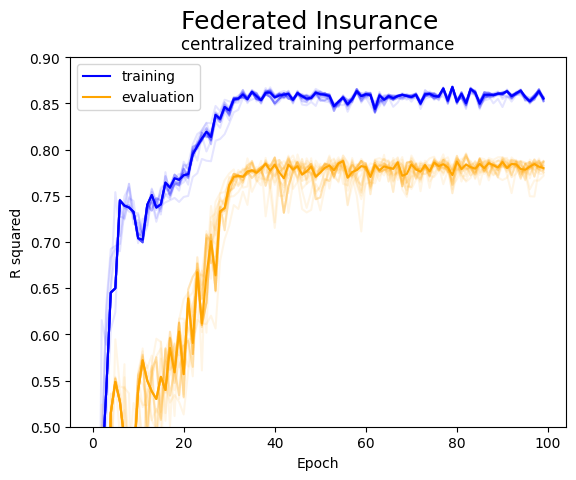

In [211]:
# plot train result
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .1)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .1)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epoch")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('centralized training performance')
plt.legend()
plt.show()

### Test
---

In [176]:
# compute test
results_test_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    #train_indices = [split[1][0] for split in client_splits]
    test_indices = [split[1][1] for split in client_splits]

    data_test = pd.concat([clients[i].iloc[test_indices[i]] for i in range(len(clients))])
    X_test = data_test[features]
    y_test = data_test[target]

    model = results_ctr[i].model
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


In [185]:
# show test results
pd.DataFrame(results_test_ctr).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,2522.600625,2522.600625,3.365286e+07,0.647688
std,48.187150,48.187150,4.698439e+05,0.005468
min,2443.913330,2443.913330,3.242050e+07,0.640448
25%,2482.158447,2482.158447,3.335837e+07,0.643379
50%,2520.580078,2520.580078,3.375714e+07,0.645517
75%,2562.074707,2562.074707,3.394860e+07,0.651644
max,2606.295410,2606.295410,3.429384e+07,0.660304
